# Cell cycle identification demo

In [1]:
# Import libraries
import os
import anndata
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc

In [2]:
# Set up the paths
base_path = '/home/unix/jiahao/wanglab/Data/Analyzed/sample-dataset-output/cell-culture-3D'
output_path = os.path.join(base_path, 'output')
expr_path = os.path.join(base_path, 'expr')
image_path = os.path.join(base_path, 'images')
figure_path = os.path.join(base_path, 'figures')
if not os.path.exists(figure_path):
    os.mkdir(figure_path)

# Load the data 
adata = sc.read_h5ad(os.path.join(expr_path, '2023-12-08-cell_culture.h5ad'))
adata

AnnData object with n_obs × n_vars = 1950 × 998
    obs: 'area', 'x', 'y', 'seg_label'
    layers: 'cytoplasm', 'nucleus'

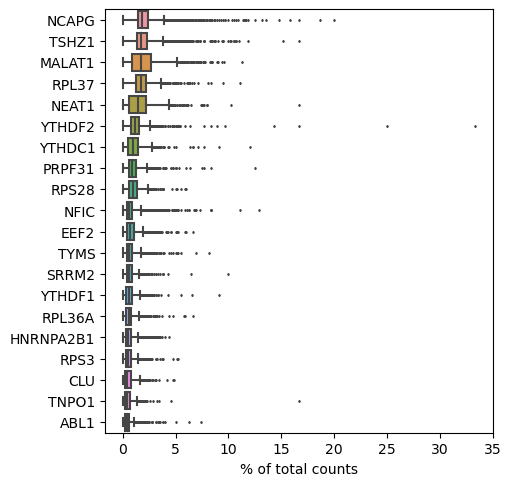

In [3]:
# Calculate the QC metrics
sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pl.highest_expr_genes(adata, n_top=20)

In [4]:
# Filtering the data
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

AnnData object with n_obs × n_vars = 1430 × 998
    obs: 'area', 'x', 'y', 'seg_label', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'filter_cell_vol'

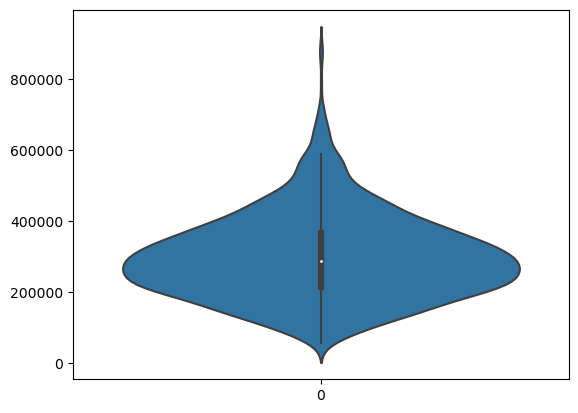

In [5]:
# Filtering the data based on segmentation volume
sns.violinplot(data=adata.obs['area'])

bot5, top5 = np.percentile(adata.obs['area'], q=5), np.percentile(adata.obs['area'], q=95)
adata.obs['filter_cell_vol'] = np.logical_and(adata.obs['area']>bot5, adata.obs['area']<top5)
adata = anndata.AnnData(X=adata.X[adata.obs['filter_cell_vol']], obs=adata.obs[adata.obs['filter_cell_vol']], var=pd.DataFrame(index=adata.var.index))
adata

In [6]:
# Preprocess the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [7]:
# Load the cell cycle genes
s_genes = pd.read_excel('./cell_cycle_markers.xlsx', sheet_name='G1_S', header=None)[0].to_list()
g2m_genes = pd.read_excel('./cell_cycle_markers.xlsx', sheet_name='G2_M', header=None)[0].to_list()
cell_cycle_genes = s_genes + g2m_genes

In [8]:
# Calculate the cell cycle scores
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

/home/unix/jiahao/anaconda3/envs/starfinder/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


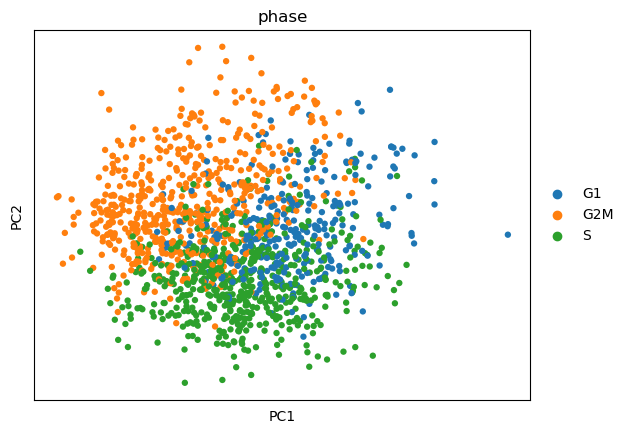

In [9]:
# Visualize the cell cycle labels on PCA
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')